In [3]:
import os
import random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from CL_utilities.ContrastiveGenerator import ContrastiveGenerator
from distance.CL_Euclidean_Distance import CL_Euclidean_Distance
from CL_utilities.CL_mapping import Generate_pack_of_images
from CL_utilities import CL_visualization
from CL_utilities import CL_loss


In [4]:
#HYPERPARAMETERS

epochs = 10
batch_size = 8
margin = 1 # margin for contrastive loss

In [5]:
path = r"/home/c100rczyk/VSCode/InsERT/Fruits"
# path = r"C:\Users\matim\Documents\Fruits360\archive\fruits-360_dataset\fruits-360\Training"
# path = r"C:\Users\matim\Documents\FruitDataset\archive"

number_of_pairs = 200 #16   # WE Create number_of_pairs * 2  pairs.
generator = ContrastiveGenerator(path, number_of_pairs)

27


# Generator for creating dataset

In [7]:
dataset = tf.data.Dataset.from_generator( generator.get_next_element,
                                          output_signature=(tf.TensorSpec(shape=(), dtype=tf.string),
                                                            tf.TensorSpec(shape=(), dtype=tf.string),
                                                            tf.TensorSpec(shape=(), dtype=tf.float32)))

# Create new pack of images and label

In [8]:
IMAGE_SIZE = (258, 320)

pack_of_images = Generate_pack_of_images(IMAGE_SIZE, batch_size)
img_pack = dataset.map( lambda image_path1, image_path2, value: (pack_of_images(image_path1, image_path2, value))).batch(batch_size)
touple_of_products = img_pack

print(touple_of_products)

<_BatchDataset element_spec=((TensorSpec(shape=(None, 258, 320, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 258, 320, 3), dtype=tf.float32, name=None)), TensorSpec(shape=(None,), dtype=tf.float32, name=None))>


# (1.) See Documentation to get info about structure of dataset

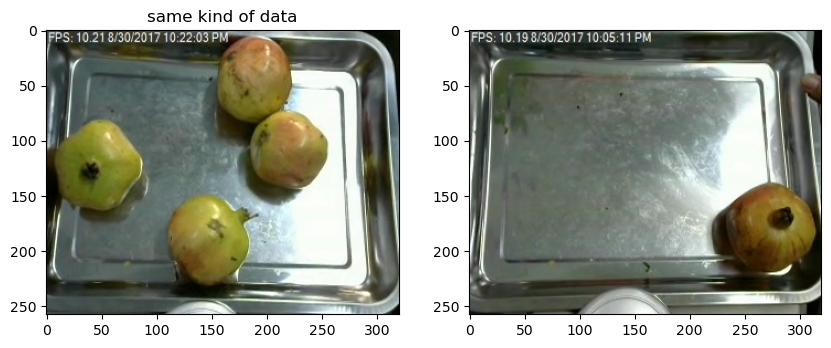

Etykieta: 0


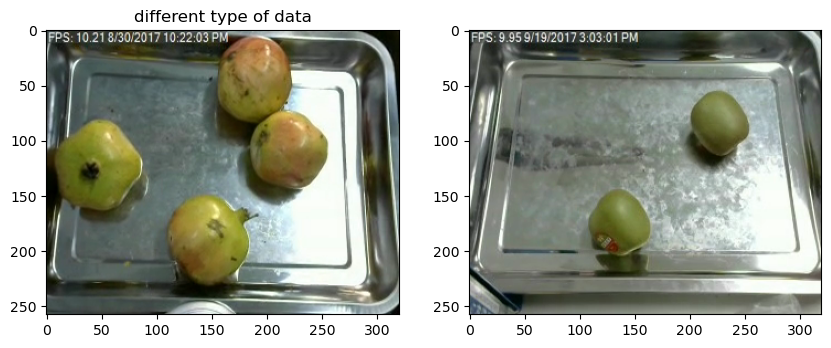

Etykieta: 1


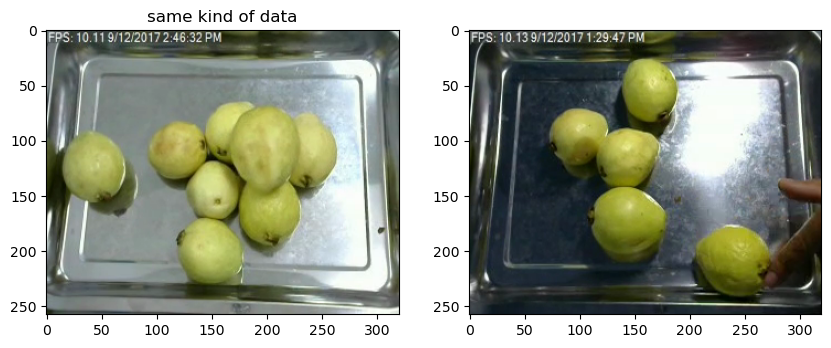

Etykieta: 0


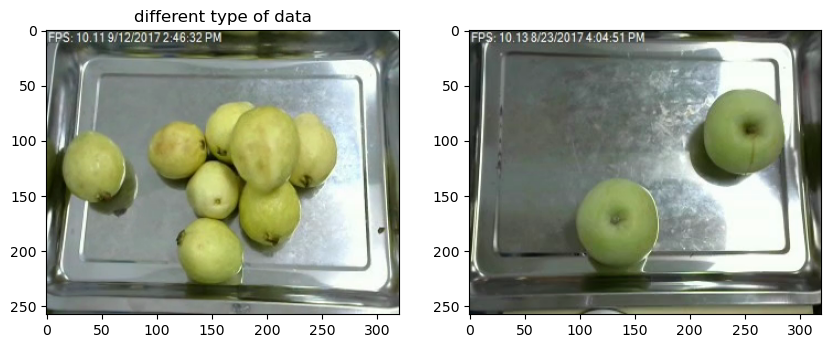

Etykieta: 1


2024-04-08 22:18:54.072910: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [9]:
CL_visualization.visualize(touple_of_products)

In [10]:
import keras

input = keras.layers.Input((258,320,3))
x = keras.layers.BatchNormalization()(input)
x = keras.layers.Conv2D(32, (5,5), activation="relu")(x)  # ilość elementów filtra, rozmiar filtra
x = keras.layers.AveragePooling2D(pool_size=(2,2))(x)
x = keras.layers.Conv2D(64, (3,3), activation="relu")(x)
x = keras.layers.AveragePooling2D(pool_size=(2,2))(x)
x = keras.layers.Flatten()(x)

x = keras.layers.Dense(64, activation="relu")(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dense(16, activation="relu")(x)
embedding_network = keras.Model(input, x)   # tworzę instancję modelu. Model nazywam embedding network
                                            # używam tego do dalszego definiowania modelu


In [11]:
input_1 = keras.layers.Input((258,320,3))
input_2 = keras.layers.Input((258,320,3))

tower_1 = embedding_network(input_1)
tower_2 = embedding_network(input_2)

euclidean_distance = CL_Euclidean_Distance()
merge_layer = keras.layers.Lambda(euclidean_distance, output_shape=(1,))([tower_1, tower_2])

normal_layer = keras.layers.BatchNormalization()(merge_layer)
output_layer = keras.layers.Dense(1, activation="sigmoid")(normal_layer)

siamese = keras.Model(inputs=[input_1, input_2], outputs=output_layer)

In [12]:
siamese.compile(loss=CL_loss.loss(margin=margin), optimizer='adam', metrics=['accuracy'])
siamese.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 258, 320,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_2       │ (None, 258, 320,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_1        │ (None, 16)        │ 19,830,556 │ input_layer_1[0]… │
│ (Functional)        │                   │            │ input_layer_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 1)         │          0 │ functional_1[0][… │
│                     │                   │            │ functional_1[1][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1)         │          4 │ lambda[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 1)         │          2 │ batch_normalizat… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 19,830,562 (75.65 MB)

 Trainable params: 19,830,426 (75.65 MB)

 Non-trainable params: 136 (544.00 B)

In [ ]:
# How many samples we have, and how many we want in train and validation
num_samples = sum(1 for _ in touple_of_products)
train_size = int(0.8 * num_samples)
val_size = num_samples - train_size
# .take() to get from actual batch
train_dataset = touple_of_products.take(train_size)
val_dataset = touple_of_products.skip(train_size)


Trained_model_data = siamese.fit(train_dataset, 
                                 validation_data= val_dataset, 
                                 batch_size = batch_size,
                                 epochs = epochs
                                )

Epoch 1/10


2024-04-08 22:19:00.299542: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


     40/Unknown 27s 602ms/step - accuracy: 0.4144 - loss: 0.3196

2024-04-08 22:19:27.122348: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/home/c100rczyk/anaconda3/lib/python3.11/contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


40/40 ━━━━━━━━━━━━━━━━━━━━ 29s 650ms/step - accuracy: 0.4146 - loss: 0.3195 - val_accuracy: 0.5000 - val_loss: 0.4492
Epoch 2/10


2024-04-08 22:19:28.955608: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 599ms/step - accuracy: 0.3955 - loss: 0.3272

2024-04-08 22:19:52.974300: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


40/40 ━━━━━━━━━━━━━━━━━━━━ 26s 642ms/step - accuracy: 0.3966 - loss: 0.3266 - val_accuracy: 0.5125 - val_loss: 0.4032
Epoch 3/10


2024-04-08 22:19:54.654787: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 616ms/step - accuracy: 0.4828 - loss: 0.2979

2024-04-08 22:20:19.392039: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


40/40 ━━━━━━━━━━━━━━━━━━━━ 26s 661ms/step - accuracy: 0.4817 - loss: 0.2980 - val_accuracy: 0.4625 - val_loss: 0.2980
Epoch 4/10


2024-04-08 22:20:21.096844: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 613ms/step - accuracy: 0.4851 - loss: 0.3000

2024-04-08 22:20:45.705075: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


40/40 ━━━━━━━━━━━━━━━━━━━━ 26s 659ms/step - accuracy: 0.4856 - loss: 0.2995 - val_accuracy: 0.4250 - val_loss: 0.2946
Epoch 5/10


2024-04-08 22:20:47.440558: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 617ms/step - accuracy: 0.5209 - loss: 0.2664

2024-04-08 22:21:12.206692: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


40/40 ━━━━━━━━━━━━━━━━━━━━ 27s 662ms/step - accuracy: 0.5209 - loss: 0.2663 - val_accuracy: 0.5000 - val_loss: 0.2682
Epoch 6/10


2024-04-08 22:21:13.943236: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 621ms/step - accuracy: 0.5275 - loss: 0.2703

2024-04-08 22:21:38.837407: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


40/40 ━━━━━━━━━━━━━━━━━━━━ 27s 665ms/step - accuracy: 0.5269 - loss: 0.2703 - val_accuracy: 0.4500 - val_loss: 0.2934
Epoch 7/10


2024-04-08 22:21:40.523423: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 622ms/step - accuracy: 0.4559 - loss: 0.2880

2024-04-08 22:22:05.446185: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


40/40 ━━━━━━━━━━━━━━━━━━━━ 27s 667ms/step - accuracy: 0.4564 - loss: 0.2876 - val_accuracy: 0.5250 - val_loss: 0.2552
Epoch 8/10


2024-04-08 22:22:07.206700: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 624ms/step - accuracy: 0.4631 - loss: 0.2771

2024-04-08 22:22:32.260636: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


40/40 ━━━━━━━━━━━━━━━━━━━━ 27s 671ms/step - accuracy: 0.4632 - loss: 0.2770 - val_accuracy: 0.4250 - val_loss: 0.2943
Epoch 9/10


2024-04-08 22:22:34.047512: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


 9/40 ━━━━━━━━━━━━━━━━━━━━ 19s 620ms/step - accuracy: 0.5659 - loss: 0.2402